In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from functools import partial
#from functools import wraps

from keras.layers import *
from keras.models import *
from keras.datasets import mnist
from keras.optimizers import RMSprop
import keras.backend as K 

In [2]:
batch_size = 32
iterations = 50000

d_loss = []
g_loss = []
gp_loss = []

x_train = np.load('datasets/faces.npy')

x_train = x_train.astype('float32') / 255.0

print(str(x_train.shape[0]) + ' images.')

image_indices = np.random.randint(0, x_train.shape[0], [4])
real_images = x_train[image_indices]


1000 images.


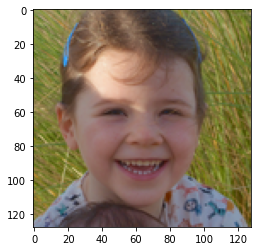

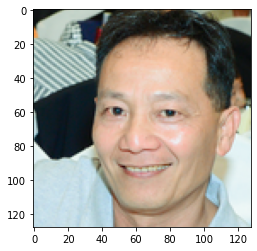

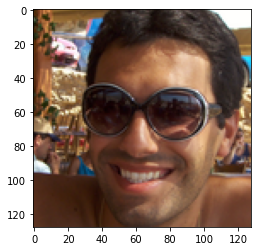

In [3]:
for i in range(3):
    plt.figure(i)
    plt.imshow(real_images[i])

plt.show()

In [4]:
def r1_gradient_penalty(y_true, y_pred, samples):
    gradients = K.gradients(y_pred, samples)[0]

    gradients_sqr = K.square(gradients)
    gradient_norm = K.sum(gradients_sqr, axis=[1,2,3])

    return K.mean(gradient_norm)

In [5]:
def AdaIn(x):
    mean = K.mean(x[0], axis=[1,2], keepdims=True)
    std = K.std(x[0], axis=[1,2], keepdims=True)
    y = (x[0] - mean) / std

    pool_shape = [-1,1,1,y.shape[-1]]
    scale = K.reshape(x[1], pool_shape)
    bias = K.reshape(x[2], pool_shape)

    return y * scale + bias

In [6]:
def crop_to_fit(x):
    height = x[1].shape[1]
    width = x[1].shape[2]

    return x[0][:, :height*2, :width*2, :]

In [7]:
def g_block(input_tensor, latent_vector, inc_noise, filters):
    gamma = Dense(filters, bias_initializer = 'ones')(latent_vector)
    beta = Dense(filters)(latent_vector)

    noise = Lambda(crop_to_fit)([inc_noise, input_tensor])

    out = UpSampling2D()(input_tensor)
    out = Conv2D(filters, 3, padding = 'same')(out)
    out = add([out, noise])
    out = Lambda(AdaIn)([out, gamma, beta])
    out = Activation('relu')(out)

    return out

In [8]:
def d_block(input_tensor, filters):
    out = Conv2D(filters, 3, padding='same')(input_tensor)
    out = LeakyReLU(0.2)(out)
    out = AveragePooling2D()(out)

    return out

In [9]:
latent_input = Input([64])

noise_input = Input([128, 128, 1])

latent = Dense(64, activation = 'relu')(latent_input)
latent = Dense(64, activation = 'relu')(latent)
latent = Dense(64, activation = 'relu')(latent)

x = Dense(1)(latent_input)
x = Lambda(lambda x: x * 0 + 1)(x)

x = Dense(4*4*64, activation = 'relu')(x)
x = Reshape([4,4,64])(x)

x = g_block(x, latent, noise_input, 128)
x = g_block(x, latent, noise_input, 64)
x = g_block(x, latent, noise_input, 32)
x = g_block(x, latent, noise_input, 16)
x = g_block(x, latent, noise_input, 8)

image_output = Conv2D(3, 1, padding='same', activation='sigmoid')(x)

generator = Model(inputs = [latent_input, noise_input], outputs = image_output)

generator.summary()



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1)            65          input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           dense_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1024)         2048        lambda[0][0]                     
_______________________________________________________________________________________

In [10]:
image_input = Input([128, 128, 3])

x = d_block(image_input, 8)
x = d_block(x, 16)
x = d_block(x, 32)
x = d_block(x, 64)
x = d_block(x, 128)

x = Conv2D(128, 3, padding = 'same')(x)
x = LeakyReLU(0.2)(x)
x = Flatten()(x)

class_output = Dense(1)(x)

discriminator = Model(inputs = image_input, outputs = class_output)

discriminator.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 8)       224       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 8)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 16)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 32, 32, 16)       

In [11]:
for layer in discriminator.layers:
    layer.trainable = True

for layer in generator.layers:
    layer.trainable = False

real_image = Input([128, 128, 3])

validity_real = discriminator(real_image)

latent_input = Input([64])
noise_input = Input([128, 128, 1])

fake_image = generator([latent_input, noise_input])

validity_fake = discriminator(fake_image)

partial_gp = partial(r1_gradient_penalty, samples = real_image)

DiscriminatorModel = Model(inputs = [real_image, latent_input, noise_input], outputs = [validity_real, validity_fake, validity_real])

DiscriminatorModel.compile(optimizer=RMSprop(lr=0.0002),
                            loss = ['mean_squared_error', 'mean_squared_error', partial_gp],
                            loss_weights = [1,1,10])

In [12]:
for layer in discriminator.layers:
    layer.trainable = False

for layer in generator.layers:
    layer.trainable = True

latent_input = Input([64])
noise_input = Input([128, 128, 1])

fake_image = generator([latent_input, noise_input])

validity = discriminator(fake_image)

GeneratorModel = Model(inputs = [latent_input, noise_input], outputs = validity)

GeneratorModel.compile(optimizer = RMSprop(lr=0.0002), loss = 'mean_squared_error')

In [15]:
for i in range(iterations):
    print ('\rIteration ' + str(i), end= '')

    real_labels = np.ones([batch_size, 1])
    fake_labels = np.zeros([batch_size, 1])
    dummy_labels = np.ones([batch_size, 1])

    image_indices = np.random.randint(0, x_train.shape[0] -1, [batch_size])
    real_images = x_train[image_indices]
    latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 64])
    noise = np.random.uniform(-1.0, 1.0, [batch_size, 128, 128, 1])

    loss = DiscriminatorModel.train_on_batch([real_images, latent_vectors, noise], [real_labels, fake_labels, dummy_labels])
    d_loss.append(loss[1]/2 + loss[2]/2)
    gp_loss.append(loss[3])

    latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 64])
    noise = np.random.uniform(-1.0, 1.0, [batch_size, 128, 128, 1])
    
    loss = GeneratorModel.train_on_batch([latent_vectors, noise], real_labels)
    g_loss.append(loss)

Iteration 0

AttributeError: in user code:

    C:\Users\Chris\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Chris\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Chris\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Chris\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Chris\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Chris\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Chris\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    C:\Users\Chris\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\compile_utils.py:187 __call__
        self.build(y_pred)
    C:\Users\Chris\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\compile_utils.py:140 build
        self._losses = nest.map_structure(self._get_loss_object, self._losses)
    C:\Users\Chris\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\nest.py:635 map_structure
        structure[0], [func(*x) for x in entries],
    C:\Users\Chris\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\nest.py:635 <listcomp>
        structure[0], [func(*x) for x in entries],
    C:\Users\Chris\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\compile_utils.py:265 _get_loss_object
        loss_name = loss.__name__

    AttributeError: 'functools.partial' object has no attribute '__name__'


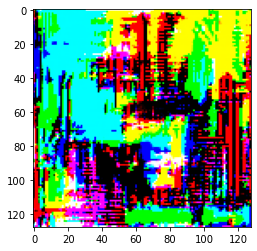

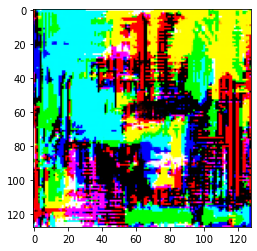

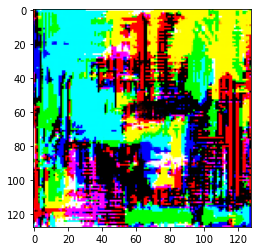

In [14]:
latent_vectors = np.random.normal(0.0, 1.0, [16, 64])
noise = np.random.uniform(-1.0, 1.0, [16, 128, 128, 1])
fake_images = generator.predict([latent_vectors, noise])

for i in range(3):
    plt.figure(i)
    plt.imshow(fake_images[i])

plt.show()